## MARBL diagnostics for vertical and horizontal nutrient distribution for ocean history files

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
from scipy import stats

### Define latest year and get the CESM data

In [4]:
start_yr = 5
num_years = 4
endyr = start_yr + num_years 
case = 'g.e22a06.G1850ECOIAF.T62_g17.4p3z.001'
user = 'kristenk'

In [5]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/scratch/{user}/archive/{case}/ocn/hist/{case}.pop.h.{yr4}-{mo2}.nc')))
        #files.extend(sorted(glob(f'/glade/scratch/{user}/{case}/run/{case}.pop.h.{yr4}-{mo2}.nc')))

doing simulation year 5 !
doing simulation year 6 !
doing simulation year 7 !
doing simulation year 8 !


In [115]:
cesm_mon_ds=xr.open_mfdataset(files,decode_times=False,decode_coords=False, concat_dim='time')

In [116]:
cesm_mon_ds.x_graze_zoo1_zint

,Array,Chunk
Bytes,23.59 MB,491.52 kB
Shape,"(48, 384, 320)","(1, 384, 320)"
Count,144 Tasks,48 Chunks
Type,float32,numpy.ndarray


### Keep only the variables we need

In [117]:
variables = ['sp_Fe_lim_surf','sp_P_lim_surf','sp_N_lim_surf',
             'diat_Fe_lim_surf', 'diat_P_lim_surf','diat_N_lim_surf',
             'diat_SiO3_lim_surf','diaz_P_lim_surf',
             'diaz_Fe_lim_surf','photoC_TOT_zint','photoC_sp_zint',
             'photoC_diat_zint','photoC_diaz_zint','photoC_cocco_zint',
             'cocco_Fe_lim_surf','cocco_C_lim_surf','cocco_N_lim_surf',
             'cocco_P_lim_surf','CaCO3_PROD_zint','SiO2_PROD','POC_FLUX_100m',
             'coccoCaCO3','diatC', 'coccoC','spC','diazC','ALK','SALT',
             'PO4','Fe','NO3','SiO3','ALK',
            'zoo1C','zoo2C','zoo3C','x_graze_zoo1_zint','x_graze_zoo2_zint',
            'x_graze_zoo3_zint'] 
coords = {'x':'TLONG','y':'TLAT'}

In [118]:
keepthese=['z_t','z_t_150m','time_bound','TAREA','PO4','Fe','NO3','SiO3','ALK','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
cesm_mon_ds = cesm_mon_ds.drop([v for v in cesm_mon_ds.variables if v not in keep_vars])

In [119]:
cesm_ann_ds=cesm_mon_ds.mean(dim='time')

#### World Ocean Atlas 2013

In [80]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc' 

In [46]:
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)

In [47]:
ds_woa['z_t'] = cesm_ann_ds.z_t

In [48]:
NO3_diff = cesm_ann_ds.NO3 - ds_woa.NO3
PO4_diff = cesm_ann_ds.PO4 - ds_woa.PO4
SiO3_diff = cesm_ann_ds.SiO3 - ds_woa.SiO3

In [49]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01

In [50]:
rmse_global = xr.Dataset({v: cesm_ann_ds[v] for v in ['z_t']})

In [51]:
#help(esmlab.statistics)
rmse_global['NO3']=esmlab.statistics.weighted_rmsd(cesm_ann_ds.NO3, ds_woa.NO3, dim=['nlat', 'nlon'], weights=area)
rmse_global['PO4']=esmlab.statistics.weighted_rmsd(cesm_ann_ds.PO4, ds_woa.PO4, dim=['nlat', 'nlon'], weights=area)
rmse_global['SiO3']=esmlab.statistics.weighted_rmsd(cesm_ann_ds.SiO3, ds_woa.SiO3, dim=['nlat', 'nlon'], weights=area)

In [52]:
rmse_global.PO4.values

array([0.22590857, 0.23153266, 0.24510578, 0.25433287, 0.26027107,
       0.26583364, 0.27424298, 0.28171551, 0.2901114 , 0.29626946,
       0.29598114, 0.29142459, 0.28947315, 0.28069006, 0.27773184,
       0.27398975, 0.26969398, 0.26971874, 0.26509639, 0.26401024,
       0.26135439, 0.26339334, 0.25645131, 0.25123367, 0.24509771,
       0.23805931, 0.23093847, 0.22523324, 0.21624516, 0.20294212,
       0.18919028, 0.17424246, 0.16041741, 0.14507409, 0.13725982,
       0.12445273, 0.11375223, 0.10147768, 0.08278959, 0.08121255,
       0.07449539, 0.07112979, 0.07349138, 0.06086602, 0.06010969,
       0.05250065, 0.05829972, 0.05763674, 0.05569425, 0.05749241,
       0.05547161, 0.05216176, 0.05109306, 0.0516931 , 0.04737575,
       0.04680502, 0.04970228, 0.05395703, 0.05690077, 0.04996947])

In [53]:
rmse_global.NO3.values

array([2.54072465, 2.64371663, 2.76989394, 2.8858301 , 3.01953728,
       3.15953972, 3.38878589, 3.60995183, 3.80029347, 3.96802731,
       3.96722735, 3.96125339, 4.02471176, 3.98206662, 4.02768544,
       4.06571952, 4.09237024, 4.16612661, 4.17202269, 4.22618218,
       4.24551669, 4.30641141, 4.22089494, 4.17698058, 4.11815985,
       4.03624575, 3.94715072, 3.82103468, 3.67035659, 3.48711406,
       3.23717745, 2.98780271, 2.75775035, 2.60779491, 2.46954174,
       2.24031298, 1.99700719, 1.72338349, 1.48654254, 1.40887952,
       1.2400299 , 1.08667129, 0.97646234, 0.85435023, 0.77321777,
       0.67047667, 0.71756654, 0.67947128, 0.67043781, 0.662292  ,
       0.61865679, 0.57542667, 0.53536264, 0.49981843, 0.49759607,
       0.50962087, 0.45936444, 0.4552429 , 0.4097268 , 0.45968041])

In [54]:
rmse_global.SiO3.values

array([9.32010559, 9.38271951, 9.23402209, 9.10058409, 8.94249799,
       8.73179588, 8.72989405, 8.75061124, 8.89665821, 9.05790129,
       9.13171224, 9.26427058, 9.33025563, 9.17239617, 9.00811378,
       8.83013067, 8.66826017, 8.58150023, 8.34520407, 8.2220169 ,
       8.01597129, 7.92011997, 7.64350561, 7.46717108, 7.35107564,
       7.21465557, 7.07336316, 6.98567318, 6.83559178, 6.69295897,
       6.5636938 , 6.53074432, 6.34802186, 6.26999193, 6.40502768,
       6.39015015, 6.26416803, 5.91635639, 5.76529679, 5.59889879,
       5.22589645, 4.88451367, 4.46014791, 4.11861957, 3.92448607,
       3.86603125, 3.97182228, 3.98786861, 4.0154557 , 3.98365761,
       3.84659164, 3.6210089 , 3.39707012, 3.19660452, 3.06738866,
       3.26976609, 3.10929913, 3.11601332, 2.88085104, 2.74185632])

#### Surface nutrients

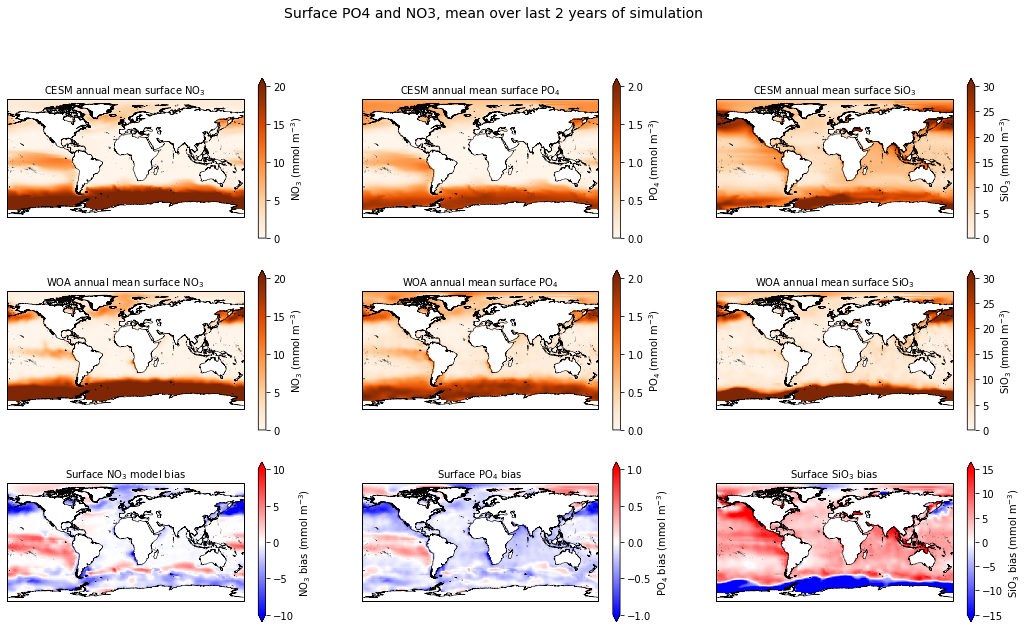

In [55]:
fig = plt.figure(figsize=(18,10))
plt.suptitle('Surface PO4 and NO3, mean over last 2 years of simulation', fontsize=14)

####################NO3
#COLUMN 1  - NO3
#---- CESM panel
ax = fig.add_subplot(3,3,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface NO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 cesm_ann_ds.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,4, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface NO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,7, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface NO$_3$ model bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 NO3_diff.isel(z_t=0), vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')



####################PO4
#---- CESM panel
ax = fig.add_subplot(3,3,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface PO$_4$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 cesm_ann_ds.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,5, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface PO$_4$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,8, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface PO$_4$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 PO4_diff.isel(z_t=0), vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')



####################SiO3
#---- CESM panel
ax = fig.add_subplot(3,3,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface SiO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 cesm_ann_ds.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,6, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface SiO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,9, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface SiO$_3$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 SiO3_diff.isel(z_t=0), 
                  vmin=-15, vmax=15, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)')



### Global nutrient profiles

In [56]:
ds_glb = xr.Dataset({v: cesm_ann_ds[v] for v in ['z_t']})
ds_glb['NO3']= esmlab.weighted_mean(cesm_ann_ds['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
ds_glb['PO4']= esmlab.weighted_mean(cesm_ann_ds['PO4'], weights=area, dim=['nlat', 'nlon']).compute()
ds_glb['SiO3']= esmlab.weighted_mean(cesm_ann_ds['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()

In [57]:
ds_glb_woa = xr.Dataset({v: cesm_ann_ds[v] for v in ['z_t']})
ds_glb_woa['NO3'] = esmlab.weighted_mean(ds_woa['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
ds_glb_woa['PO4'] = esmlab.weighted_mean(ds_woa['PO4'], weights=area, dim=['nlat', 'nlon']).compute()
ds_glb_woa['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()

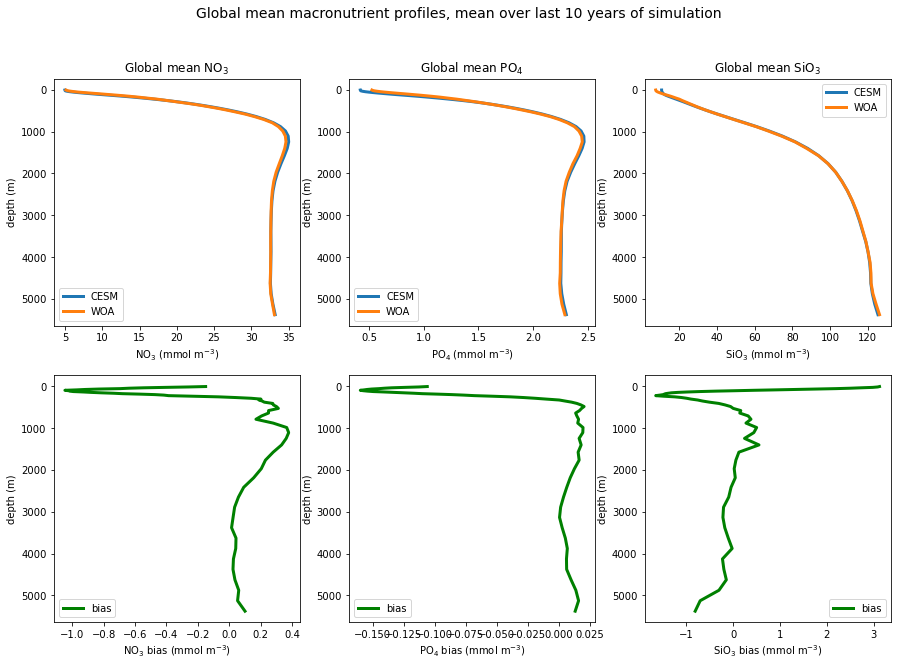

In [58]:
fig = plt.figure(figsize=(15,10))

plt.suptitle('Global mean macronutrient profiles, mean over last 10 years of simulation', fontsize=14)


#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Global mean NO$_3$')
ax.plot(ds_glb['NO3'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['NO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('Global mean PO$_4$')
ax.plot(ds_glb['PO4'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['PO4'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('Global mean SiO$_3$')
ax.plot(ds_glb['SiO3'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['SiO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - NO3 diff

ax = fig.add_subplot(2,3,4)
ax.plot(ds_glb['NO3'].values - ds_glb_woa['NO3'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4 diff

ax = fig.add_subplot(2,3,5)
ax.plot(ds_glb['PO4'].values - ds_glb_woa['PO4'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3 diff

ax = fig.add_subplot(2,3,6)
ax.plot(ds_glb['SiO3'].values - ds_glb_woa['SiO3'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()



### Phytoplankton nutrient limitation at surface

In [86]:
#most limiting nutrient - concatenate the limitation terms so that nutrient limitation terms are each along the 'nutrient' dimension
# 0 = PO4
# 1 = Fe
# 2 = NO3 (only for sp and diat)
# 3 = Si (only for diat)
# 3 = C (only for cocco)

limarray_sp=xr.concat((cesm_ann_ds.sp_P_lim_surf, cesm_ann_ds.sp_Fe_lim_surf,cesm_ann_ds.sp_N_lim_surf),dim='nutrient')
limarray_diat=xr.concat((cesm_ann_ds.diat_P_lim_surf, cesm_ann_ds.diat_Fe_lim_surf, cesm_ann_ds.diat_N_lim_surf, cesm_ann_ds.diat_SiO3_lim_surf),dim='nutrient')
limarray_diaz=xr.concat((cesm_ann_ds.diaz_P_lim_surf, cesm_ann_ds.diaz_Fe_lim_surf),dim='nutrient')
limarray_cocco=xr.concat((cesm_ann_ds.cocco_P_lim_surf, cesm_ann_ds.cocco_Fe_lim_surf, cesm_ann_ds.cocco_N_lim_surf, cesm_ann_ds.cocco_C_lim_surf),dim='nutrient')

In [87]:
most_lim_sp=limarray_sp.argmin(dim='nutrient', skipna=False)
most_lim_diat=limarray_diat.argmin(dim='nutrient', skipna=False)
most_lim_diaz=limarray_diaz.argmin(dim='nutrient', skipna=False)
most_lim_cocco=limarray_cocco.argmin(dim='nutrient', skipna=False)
mask = np.isnan(cesm_ann_ds.sp_N_lim_surf.squeeze())

In [88]:
most_lim_sp = most_lim_sp.squeeze()
most_lim_diat = most_lim_diat.squeeze()
most_lim_diaz = most_lim_diaz.squeeze()
most_lim_cocco = most_lim_cocco.squeeze()

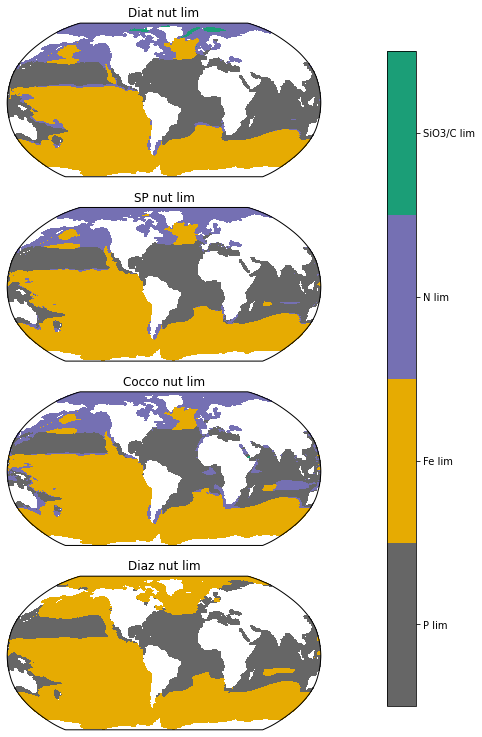

In [89]:
fig = plt.figure(figsize=(8,13))

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diat nut lim', fontsize=12)
pc=ax.pcolormesh(lons, lats, most_lim_diat.where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
colorbar_specs = {'ticks' : np.arange(0,4,1)}

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('SP nut lim', fontsize=12)
pc=ax.pcolormesh(lons, lats, most_lim_sp.where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
colorbar_specs = {'ticks' : np.arange(0,4,1)}

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Cocco nut lim', fontsize=12)
pc=ax.pcolormesh(lons, lats, most_lim_cocco.where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
colorbar_specs = {'ticks' : np.arange(0,4,1)}

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diaz nut lim', fontsize=12)
pc=ax.pcolormesh(lons, lats, most_lim_diaz.where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
colorbar_specs = {'ticks' : np.arange(0,4,1)}

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3/C lim']);

### Monthly nutrient limitations

In [90]:
#most limiting nutrient - concatenate the limitation terms so that nutrient limitation terms are each along the 'nutrient' dimension
# 0 = PO4
# 1 = Fe
# 2 = NO3 (only for sp and diat)
# 3 = Si (only for diat)
# 3 = C (only for cocco)

limarray_sp=xr.concat((cesm_mon_ds.sp_P_lim_surf, cesm_mon_ds.sp_Fe_lim_surf,cesm_mon_ds.sp_N_lim_surf),dim='nutrient')
limarray_diat=xr.concat((cesm_mon_ds.diat_P_lim_surf, cesm_mon_ds.diat_Fe_lim_surf, cesm_mon_ds.diat_N_lim_surf, cesm_mon_ds.diat_SiO3_lim_surf),dim='nutrient')
limarray_diaz=xr.concat((cesm_mon_ds.diaz_P_lim_surf, cesm_mon_ds.diaz_Fe_lim_surf),dim='nutrient')
limarray_cocco=xr.concat((cesm_mon_ds.cocco_P_lim_surf, cesm_mon_ds.cocco_Fe_lim_surf, cesm_mon_ds.cocco_N_lim_surf, cesm_mon_ds.cocco_C_lim_surf),dim='nutrient')

In [91]:
most_lim_sp=limarray_sp.argmin(dim='nutrient', skipna=False)
most_lim_diat=limarray_diat.argmin(dim='nutrient', skipna=False)
most_lim_diaz=limarray_diaz.argmin(dim='nutrient', skipna=False)
most_lim_cocco=limarray_cocco.argmin(dim='nutrient', skipna=False)
mask = np.isnan(cesm_ann_ds.sp_N_lim_surf.squeeze())

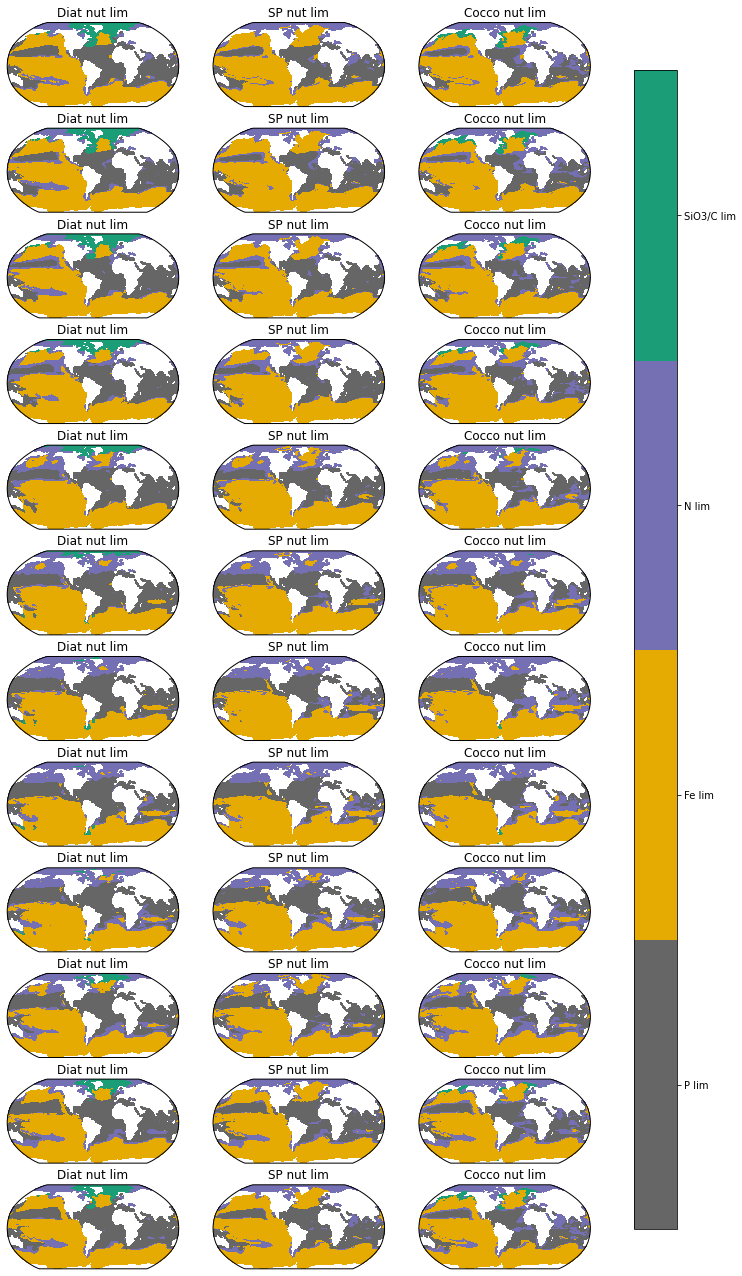

In [92]:
fig = plt.figure(figsize=(12,23))

for row in np.arange(1,13):
    ts=row-1
    
    plot = row*3 - 2
    
    #row 1 Jan
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('Diat nut lim', fontsize=12)
    pc=ax.pcolormesh(lons, lats, most_lim_diat.isel(time=ts).where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}
    
    plot = row*3 - 1
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('SP nut lim', fontsize=12)
    pc=ax.pcolormesh(lons, lats, most_lim_sp.isel(time=ts).where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}
    
    plot = row*3
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('Cocco nut lim', fontsize=12)
    pc=ax.pcolormesh(lons, lats, most_lim_cocco.isel(time=ts).where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3/C lim']);

### Look at phyto carbon pools

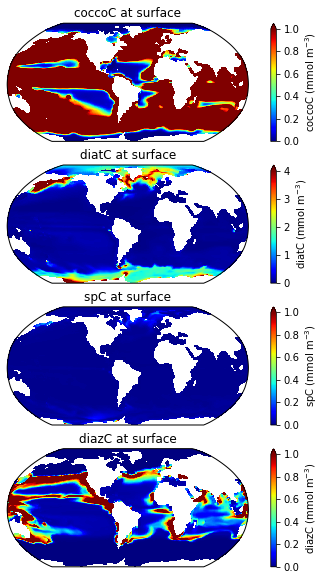

In [106]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.coccoC.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coccoC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.diatC.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=4,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diatC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.spC.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.diazC.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diazC (mmol m$^{-3}$)')

### Phytoplankton production maps

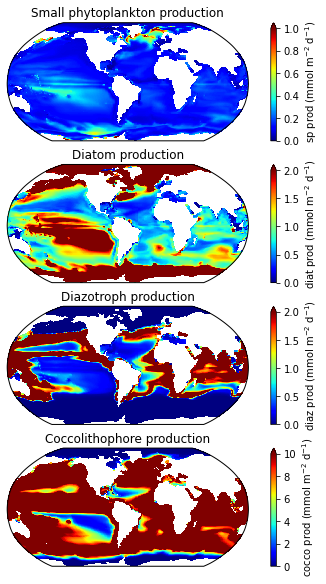

In [130]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Small phytoplankton production', fontsize=12)
tmp = cesm_ann_ds.photoC_sp_zint * 864.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='sp prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diatom production', fontsize=12)
tmp = cesm_ann_ds.photoC_diat_zint * 864.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diat prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diazotroph production', fontsize=12)
tmp = cesm_ann_ds.photoC_diaz_zint * 864.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diaz prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Coccolithophore production', fontsize=12)
tmp = cesm_ann_ds.photoC_cocco_zint * 864.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='cocco prod (mmol m$^{-2}$ d$^{-1}$)')

### Look at percent phytoC

In [95]:
phytoC = cesm_ann_ds.spC + cesm_ann_ds.diatC + cesm_ann_ds.diazC + cesm_ann_ds.coccoC
perc_sp = cesm_ann_ds.spC / (phytoC) * 100.
perc_cocco = cesm_ann_ds.coccoC / (phytoC) * 100.
perc_diat = cesm_ann_ds.diatC / (phytoC) * 100.
perc_diaz = cesm_ann_ds.diazC / (phytoC) * 100.

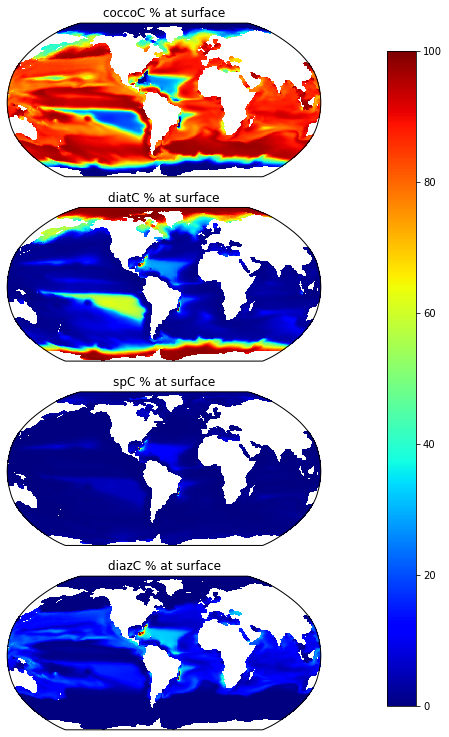

In [96]:
fig = plt.figure(figsize=(8,13))

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC % at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, perc_cocco.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC % at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, perc_diat.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC % at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, perc_sp.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC % at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, perc_diaz.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(pc, cax=cbar_ax)

### Plot zooC

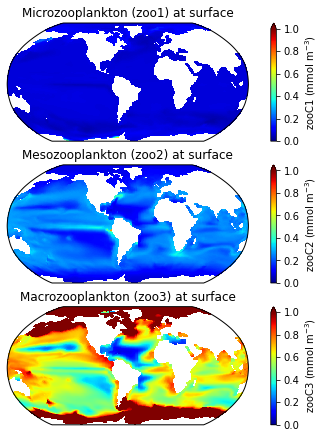

In [108]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton (zoo1) at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.zoo1C.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooC1 (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Mesozooplankton (zoo2) at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.zoo2C.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooC2 (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Macrozooplankton (zoo3) at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.zoo3C.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooC3 (mmol m$^{-3}$)')

### Plot zooplankton production maps

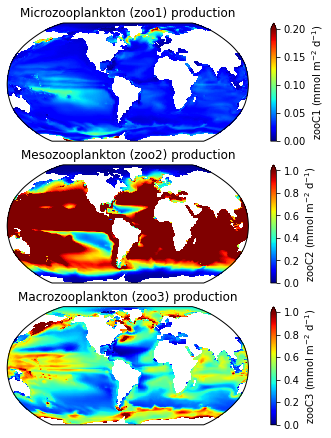

In [125]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton (zoo1) production', fontsize=12)
tmp = cesm_ann_ds.x_graze_zoo1_zint * 864.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooC1 (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Mesozooplankton (zoo2) production', fontsize=12)
tmp = cesm_ann_ds.x_graze_zoo2_zint * 864.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooC2 (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Macrozooplankton (zoo3) production', fontsize=12)
tmp = cesm_ann_ds.x_graze_zoo3_zint * 864.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooC3 (mmol m$^{-2}$ d$^{-1}$)')

### NPP

In [97]:
nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

In [98]:
variables = [f'photoC_{phyto}_zint' for phyto in ['diat', 'sp', 'diaz', 'cocco', 'TOT']]

ds_glb = xr.Dataset()
for v in variables:
    ds_glb[v] = esmlab.statistics.weighted_sum(cesm_ann_ds[v], weights=area, dim=['nlat', 'nlon'])
    ds_glb[v].attrs = cesm_ann_ds[v].attrs

    #if ds1_annmean[v].units == 'mmol/m^3 cm/s':
    ds_glb[v] = ds_glb[v] * nmols_to_PgCyr        
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

ds_glb = ds_glb.compute()
ds_glb

<xarray.Dataset>
Dimensions:            ()
Data variables:
    photoC_diat_zint   float64 3.584
    photoC_sp_zint     float64 0.2715
    photoC_diaz_zint   float64 2.724
    photoC_cocco_zint  float64 29.56
    photoC_TOT_zint    float64 36.14

### Zooplankton production (zoo grazing - zoo respiration)
#### Should be ~25% of NPP

In [100]:
variables = [f'x_graze_{zoo}_zint' for zoo in ['zoo1', 'zoo2', 'zoo3']]

ds_zooglb = xr.Dataset()
for v in variables:
    ds_zooglb[v] = esmlab.statistics.weighted_sum(cesm_ann_ds[v], weights=area, dim=['nlat', 'nlon'])
    ds_zooglb[v].attrs = cesm_ann_ds[v].attrs

    #if ds1_annmean[v].units == 'mmol/m^3 cm/s':
    ds_zooglb[v] = ds_zooglb[v] * nmols_to_PgCyr        
    ds_zooglb[v].attrs['units'] = 'Pg C yr$^{-1}$'

ds_zooglb = ds_zooglb.compute()
ds_zooglb

<xarray.Dataset>
Dimensions:            ()
Data variables:
    x_graze_zoo1_zint  float64 0.05457
    x_graze_zoo2_zint  float64 2.152
    x_graze_zoo3_zint  float64 0.691

In [ ]:
## calculate % zoo prod of NPP 

## calculate % microzooplankton (zoo1) prod of total zoo prod

### Calcification

In [72]:
## GLOBALLY integrated calcification; observation-based estimates range from 0.8 to 2.4 Pg CaCO3 per year 
## (Feely et al., 2004, Maranon et al., 2016, Smith et al., 2016, Balch et al., 2007, Iglesias-Rodriguez et al., 2002)
ds_glb['CaCO3_PROD_zint'] = esmlab.statistics.weighted_sum(cesm_ann_ds['CaCO3_PROD_zint'], weights=area, dim=['nlat', 'nlon'])
ds_glb['CaCO3_PROD_zint'] = ds_glb['CaCO3_PROD_zint'] * nmols_to_PgCyr
ds_glb['CaCO3_PROD_zint'].values
print('Globally integrated calcification is',ds_glb['CaCO3_PROD_zint'].values, 'Pg C per year')
print('(should be between 0.6 to 2.4 Pg C per year)')

Globally integrated calcification is 9.572697427879644 Pg C per year
(should be between 0.6 to 2.4 Pg C per year)


In [73]:
#read in mean PIC
pic_file = '/glade/work/kristenk/satellite_data/processed/PIC_mean2003to2018_1deg.nc'
ds_pic=xr.open_dataset(pic_file, decode_times=False)
#ds_pic.PIC

In [74]:
#convert to mmol/m3 from mg/m3
ds_pic['PIC']=ds_pic.PIC / 12.011

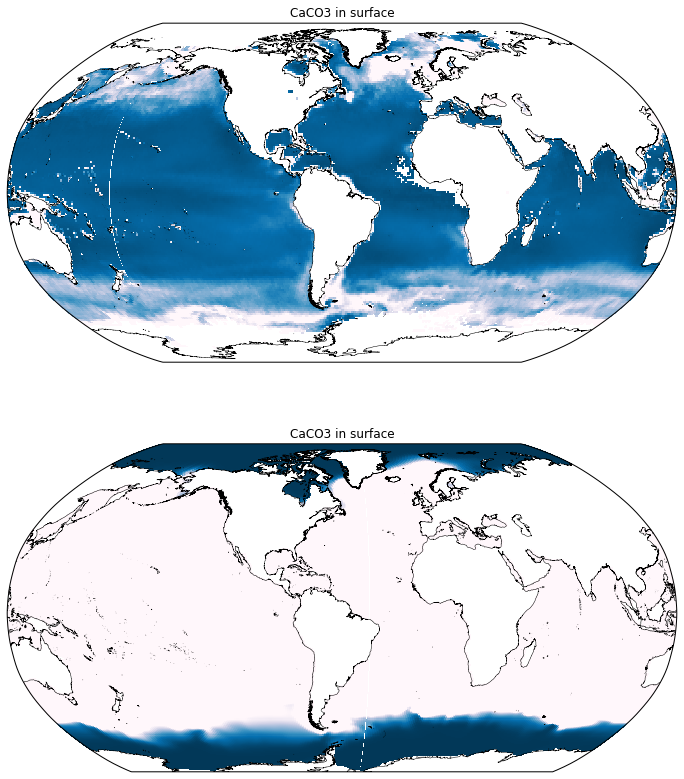

In [76]:
fig = plt.figure(figsize=(12,14))


ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CaCO3 in surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(ds_pic.lon.values, ds_pic.lat.values, ds_pic.PIC, cmap='PuBu_r',vmin=0,vmax=0.25,transform=ccrs.PlateCarree())


ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CaCO3 in surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.coccoCaCO3.isel(z_t_150m=0), cmap='PuBu_r',vmin=0,vmax=0.25,transform=ccrs.PlateCarree())



### Alkalinity

In [101]:
#just getting this for the coords (that don't have nans)
file = '/glade/work/kristenk/GLODAPv2_regridded/glodap_pop_grid/GLODAP_POPgrid_v2.nc'
ds_glodap = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_glodap['z_t']=cesm_ann_ds.z_t

In [102]:
rmse_global['ALK']=esmlab.statistics.weighted_rmsd(cesm_ann_ds.ALK, ds_glodap.ALK, dim=['nlat', 'nlon'], weights=area)
rmse_global.ALK.values

array([567.97042422, 565.19194961, 565.5128893 , 560.2471598 ,
       552.76087498, 538.98433566, 521.13441328, 499.24645725,
       473.4209059 , 445.44292005, 415.90093959, 384.99898823,
       354.55983951, 325.20506447, 298.2439962 , 273.38040569,
       249.44316812, 226.38296622, 203.83741378, 181.8017451 ,
       160.39158945, 139.57424587, 119.6669243 , 100.93457455,
        83.69966204,  68.4249512 ,  55.32124278,  44.49630413,
        35.65822889,  28.50250245,  22.73651244,  17.85894108,
        14.00827785,  11.31631214,   9.93820918,   9.30262625,
         9.0074669 ,   8.52888679,   8.05077188,   7.62498241,
         7.2119992 ,   6.75968458,   5.91136698,   5.46063244,
         5.0521154 ,   4.5518881 ,   4.37346855,   4.29176917,
         4.38586848,   4.99241556,   4.56740492,   5.21051617,
         4.64280535,   6.30344685,   5.57855078,   7.31886366,
         6.38063419,   9.56967391,  10.33592196,  18.400261  ])

In [103]:
ALK_diff = cesm_ann_ds.ALK - ds_glodap.ALK

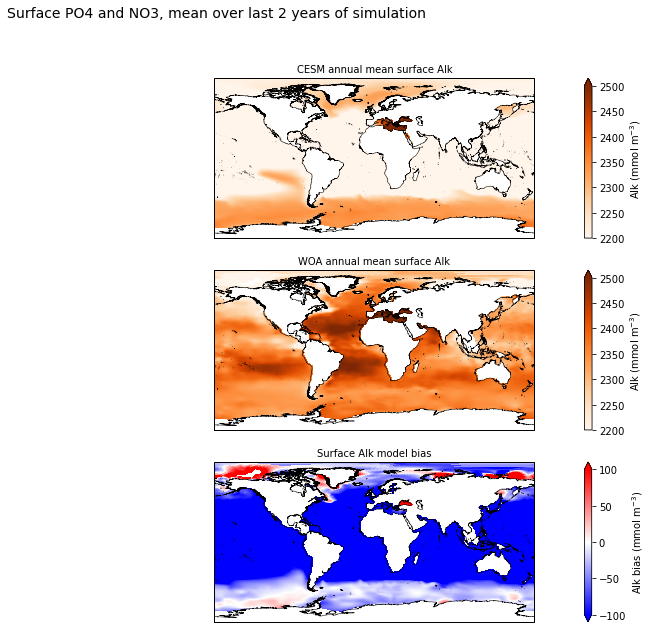

In [104]:
#plot surface alkalinity

fig = plt.figure(figsize=(18,10))
plt.suptitle('Surface PO4 and NO3, mean over last 2 years of simulation', fontsize=14)

####################NO3
#COLUMN 1  - NO3
#---- CESM panel
ax = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface Alk', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 cesm_ann_ds.ALK.isel(z_t=0), cmap='Oranges',
                  vmin=2200, vmax=2500, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface Alk', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_glodap.ALK.isel(z_t=0), cmap='Oranges',
                  vmin=2200, vmax=2500, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='Alk (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface Alk model bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 ALK_diff.isel(z_t=0), vmin=-100, vmax=100, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='Alk bias (mmol m$^{-3}$)')

In [105]:
ds_glb['POC_FLUX_100m'] = esmlab.statistics.weighted_sum(cesm_ann_ds['POC_FLUX_100m'], weights=area, dim=['nlat', 'nlon'])
ds_glb['POC_FLUX_100m'] = ds_glb['POC_FLUX_100m'] * nmols_to_PgCyr
ds_glb['POC_FLUX_100m'].values
print('Globally integrated POC flux is',ds_glb['POC_FLUX_100m'].values, 'Pg C per year')

Globally integrated POC flux is 10.502998575700722 Pg C per year
